# Usecase
## Aim
With the simulated dataset from the aircraft Turbofan engines' simulation in NASA Ames Prognostics Data Repository, we will build Machine Learning models to predict the Remaining Useful Life (RUL) of aircraft engine.

## Objectives
To keep the problem simple, we model it to predict the time period where the engine will fail with the thresholds of 20 and 50 engine cycles (flights).

+ First we will explore the dataset
+ Clease and transform into the suitable format for the model input
+ Build several models to compared among them in model performance assessment.

In [1]:
w0 = 20
w1 = 50

# Introduction

## Experimental Scenario


The engine is operating normally at the start of each time series, and develops a fault at some point during the operations. 

In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. 

The objective of the task is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.


## Datasets


The dataset consists of three multivariate time series files. It is divided into training and test subset. There is also a truth label dataset, where it shows the outcome of previous test cases.

Each time series is from a different engine  i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. 

There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

+ unit number
+ time, in cycles
+ operational setting 1
+ operational setting 2
+ operational setting 3

+ And the 21 other sensors

| Symbol | Description | Units | 
| --- | --- | --- | 
| T2 | Total temperature at fan inlet   | °R  | 
| T24 | Total temperature at LPC outlet  | °R  | 
| T30 | Total temperature at HPC outlet  | °R  | 
| T50 | Total temperature at LPT outlet  | °R  | 
| P2 | Pressure at fan inlet  | psia |
| P15 | Total pressure in bypass-duct  |  psia |
| P30 | Total pressure at HPC outlet  |  psia |
| Nf | Physical fan speed  | r/min |
| Nc | Physical core speed  | r/min |
| epr | Engine pressure ratio (P50/P2)  | –  |
| Ps30 | Static pressure at HPC outlet  | psia | |
| phi | Ratio of fuel flow to Ps30  | pps/psi |
| NRf | Corrected fan speed  | r/min | |
| NRc | Corrected core speed  | r/min |
| BPR | Bypass Ratio  | – |
| farB | Burner fuel-air ratio  | – |
| htBleed | Bleed Enthalpy  | – |
| Nf_dmd | Demanded fan speed  |  r/min |
| PCNfR_dmd | Demanded corrected fan speed  |  r/min |
| W31 | HPT coolant bleed  | lbm/s |
| W32  | LPT coolant bleed   | lbm/s |

These are the parameters for monitoring Aircraft Engine.

In [2]:
print('Data files: ')
!ls ../data

Data files: 
PM_test.txt  PM_train.txt  PM_truth.txt  readme.txt


# Data Exploration

In [3]:
# import packages
import pandas as pd
import numpy as np
import itertools
import matplotlib
import sklearn
import seaborn as sns
sns.set(style="whitegrid")

from tensorflow import keras
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, plot_confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

import io
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

In [4]:
print('tensorflow', tf.__version__,'sklearn', sklearn.__version__,'matplotlib', matplotlib.__version__, 'pandas', pd.__version__)

tensorflow 1.15.2 sklearn 0.22.1 matplotlib 3.0.2 pandas 0.25.3


## Load train data

In [5]:

train_df = pd.read_csv('../data/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle','setting_1','setting_2','setting_3','T2','T24','T30','T50','P2','P15','P30','Nf',
                    'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
print('Number of engine #id:',len(train_df.id.unique()))
train_df = train_df.sort_values(['id','cycle'])
print('Number of engine cycles (rows) in the training data: ', train_df.shape[0])
train_df.head(3)

Number of engine #id: 100
Number of engine cycles (rows) in the training data:  20631


,id,cycle,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442


**Remaining Useful Life** (number engine cycles before an event) 

In [6]:
train_df['RUL']=train_df.groupby(['id'])['cycle'].transform(max)-train_df['cycle']
train_df.RUL[0:10]

0    191
1    190
2    189
3    188
4    187
5    186
6    185
7    184
8    183
9    182
Name: RUL, dtype: int64

### Data Quality Assestment - Check missing values 
Why have I chosen a specific method for data quality assessment?

Since we use the cleaned simulated data, there is no missing values, however, there are several redundant columns which  have the same constant values for all engine cycles.

In [7]:
train_df.isnull().sum().sum()

0

In [8]:
### SCALE TRAIN DATA ###

def scale(df):
    return (df - df.min())/(df.max()-df.min())

for col in train_df.columns[2:-1]:
    train_df[col] = scale(train_df[col])
        
# Drop several redundant columns
train_df = train_df.dropna(axis=1)

train_df.head()

,id,cycle,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187


### Data Visualisation with training set

Time series visualisation w.r.t. cycle order of one sample aircraft engine


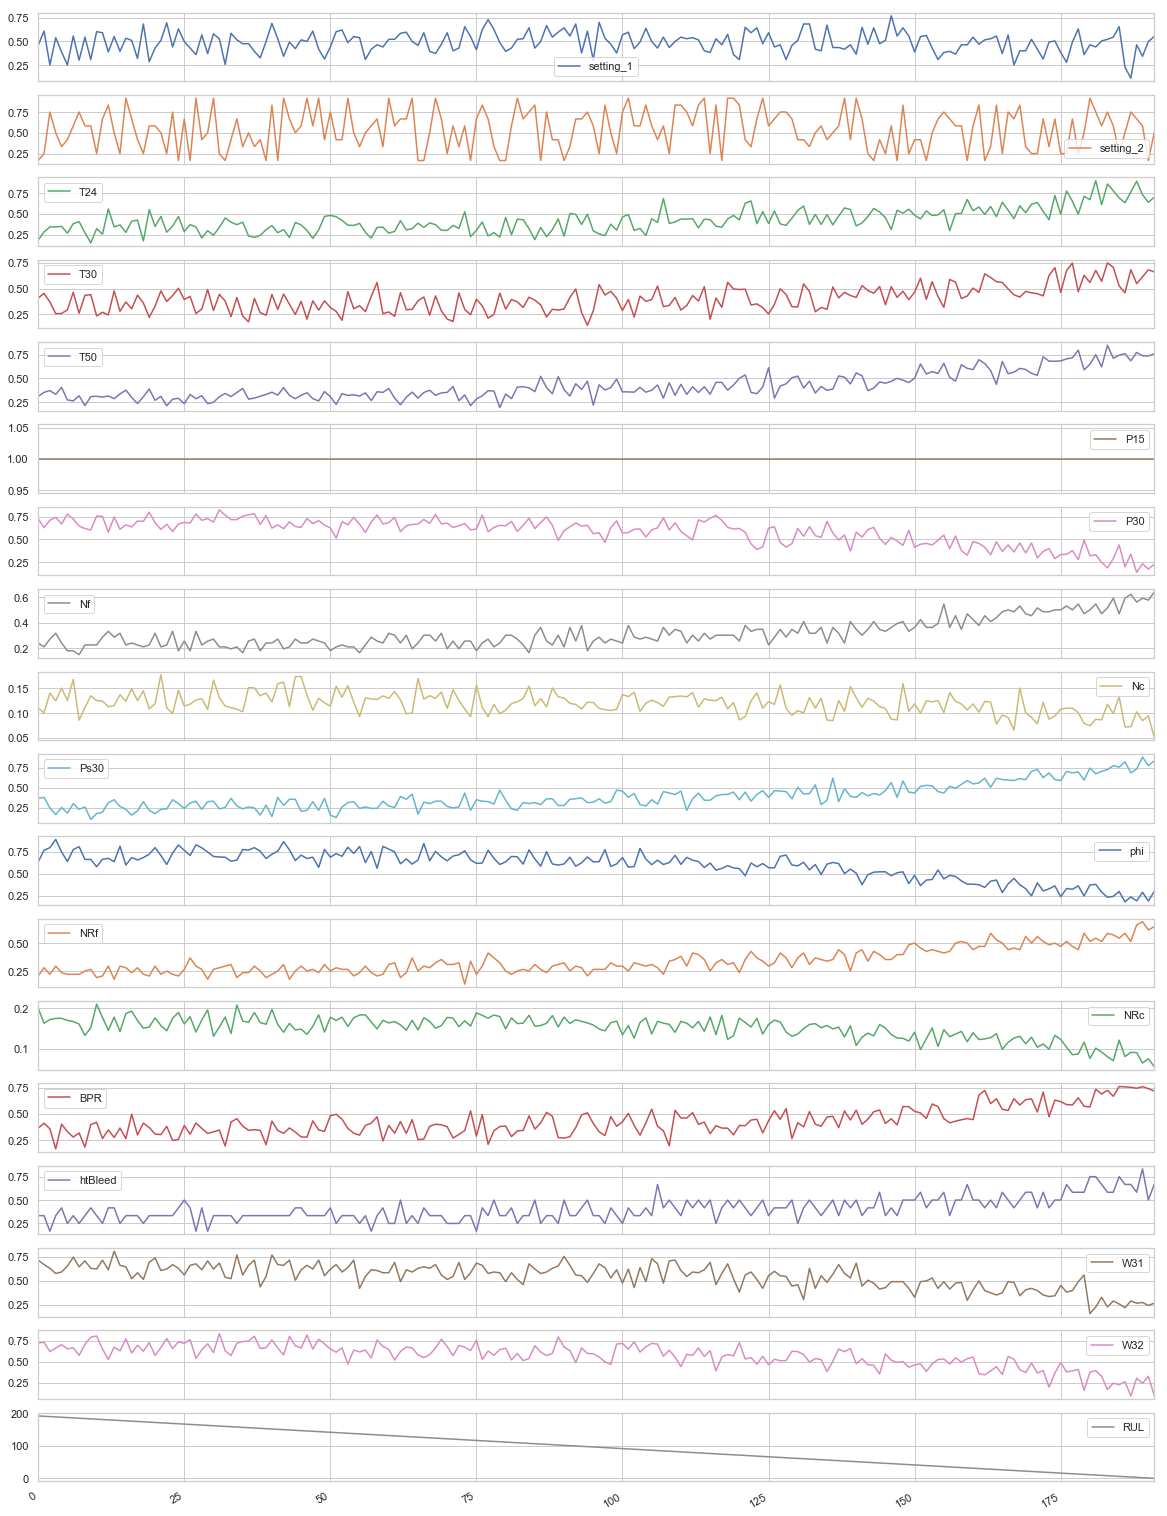

In [9]:
### plotting sensor data for engine ID ###
engine_id = train_df[train_df['id'] == 1]
print('Time series visualisation w.r.t. cycle order of one sample aircraft engine')
ax = engine_id[train_df.columns[2:]].plot(subplots=True, sharex=True, figsize=(20,30))
# plt.xlabel('Engine Cycle Time')
#plt.ylabel('Values of Settings and sensors',)


medium working time: 206.31
max working time: 362
min working time: 128


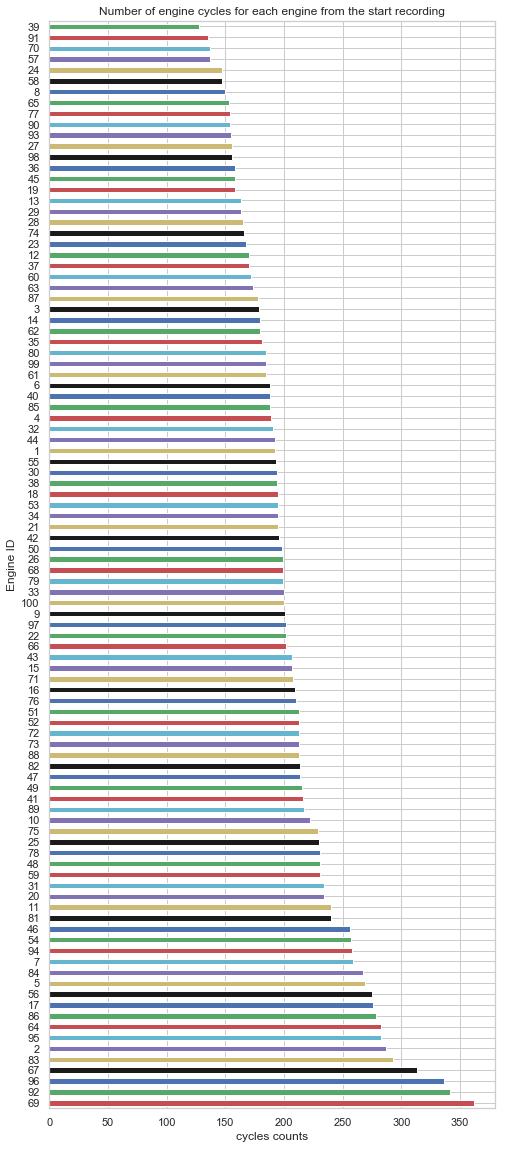

In [10]:
### PLOT TRAIN FREQ ###
plt.figure(figsize=(8,20))
train_df.id.value_counts().plot.barh(color=list('rgbkymc'))
plt.title('Number of engine cycles for each engine from the start recording')
plt.ylabel('Engine ID')
plt.xlabel('cycles counts')

print("medium working time:", train_df.id.value_counts().mean())
print("max working time:", train_df.id.value_counts().max())
print("min working time:", train_df.id.value_counts().min())

In [11]:
#correlation
correlation = train_df.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

## Load test data
### Input test feature data

In [12]:

test_df = pd.read_csv('../data/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle','setting_1','setting_2','setting_3','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
print('Number of engine #id:',len(test_df.id.unique()))
print(test_df.shape)
test_df.head(3)

Number of engine #id: 100
(13096, 26)


,id,cycle,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


### Input the ground truth of test data

In [13]:
# this shows the number of more engine cycle the aircraft can be utilised
truth_df = pd.read_csv('../data/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.columns = ['more']
truth_df = truth_df.set_index(truth_df.index + 1)

print(truth_df.shape)
truth_df.head(5)

(100, 1)


,more
1,112
2,98
3,69
4,82
5,91


In this dataset, the total number of engine cycles of an aircraft engine = the max number of engine cycle in the test data and the extra number of cycles it can fly. 

In [14]:
### CALCULATE RUL TEST ###
truth_df['max'] = test_df.groupby('id')['cycle'].max() + truth_df['more']
test_df['RUL'] = [truth_df['max'][i] for i in test_df.id] - test_df['cycle']

In [15]:
### SCALE TEST DATA ###

for col in test_df.columns[2:-1]:
    test_df[col] = scale(test_df[col])
        
# Make sure we drop the same set of cols with the training data
test_df = test_df.dropna(axis=1)
print(test_df.columns)
test_df.head()

Index(['id', 'cycle', 'setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15',
       'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31',
       'W32', 'RUL'],
      dtype='object')


,id,cycle,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,0.65625,0.692308,0.596215,0.421968,0.282214,1.0,0.608871,0.365854,0.196475,0.273973,0.534247,0.325581,0.152259,0.347076,0.375,0.500000,0.620099,142
1,1,2,0.34375,0.230769,0.182965,0.504025,0.225240,1.0,0.800403,0.292683,0.229042,0.479452,0.634703,0.395349,0.277907,0.227709,0.500,0.645455,0.645718,141
2,1,3,0.53125,0.538462,0.419558,0.464814,0.346130,1.0,0.651210,0.390244,0.248506,0.479452,0.591324,0.325581,0.192892,0.533557,0.500,0.700000,0.681104,140
3,1,4,0.77500,0.461538,0.413249,0.391587,0.449867,1.0,0.643145,0.341463,0.159080,0.328767,0.456621,0.372093,0.217896,0.282359,0.250,0.627273,0.620382,139
4,1,5,0.60000,0.461538,0.435331,0.471306,0.357974,1.0,0.661290,0.292683,0.153410,0.349315,0.632420,0.325581,0.187891,0.337009,0.125,0.618182,0.676008,138


# Feature Engineering
### Add new train label as categorical variable


Why have I chosen a specific method for feature engineering?

We will use label2 as the main target y and transform the continuous variable to the categorical format, where

+ label2=0 if RUL<=20, 
+ label2=1 if 20<RUL<=50, and 
+ label2=2 if RUL>50

In [16]:

train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 2 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 0

label = ['RUL <= 20' if x==0 else '20 < RUL <= 50' if x==1 else 'RUL > 50' for x in train_df["label2"].value_counts().keys()]
label

['RUL > 50', '20 < RUL <= 50', 'RUL <= 20']

### Pie chart of categories

In [17]:
#labels

#values
val = train_df["label2"].value_counts().values.tolist()

trace = go.Pie(labels = label ,
               values = val ,
               marker = dict(colors =  [ 'blue' ,'green', 'red'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Remaining Useful Life of Aircraft Engine",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

In [18]:
### ADD NEW LABEL TEST ###
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 2 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 0

# Model Training
Why have I chosen a specific model performance indicator?

We will use the score of 'weighted avg f1' as the main metrics, combined with 'precision' and 'recall'
## Based model where we use only the current flight as input

Why have I chosen a specific algorithm?

RandomForest is one of the best traditional machine learning methods for cases with many features, and moreover it is less bias and low variance compared to other approaches.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

train_y = train_df.label2
train_X = train_df.drop(['label1', 'label2', 'RUL', 'cycle', 'id'], axis='columns')

test_y  = test_df.label2
test_X = test_df.drop(['label1', 'label2', 'RUL', 'cycle', 'id'], axis='columns')

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((20631, 17), (20631,), (13096, 17), (13096,))

In [20]:
print('Input features:', train_X.columns.tolist())

Input features: ['setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']


### RandomForestClassifier

In [21]:
clf_1 = RandomForestClassifier(max_depth=8, random_state=7)
scores = cross_val_score(clf_1, train_X, train_y, cv=5)
print('Scores of n cross validation training', scores)

print('Cross validation mean score', np.mean(scores))

Scores of n cross validation training [0.92318876 0.90499273 0.90547746 0.89020843 0.8967523 ]
Cross validation mean score 0.9041239365604963


In [22]:
model_1 = clf_1.fit(train_X, train_y)
pred_y = clf_1.predict(test_X)
print(f'Model Accuracy', accuracy_score(test_y, pred_y))
print(classification_report(test_y, pred_y))

Model Accuracy 0.7790164935858277
              precision    recall  f1-score   support

           0       0.19      0.98      0.32       123
           1       0.12      0.41      0.18       763
           2       0.99      0.80      0.89     12210

    accuracy                           0.78     13096
   macro avg       0.43      0.73      0.46     13096
weighted avg       0.94      0.78      0.84     13096



### Confusion matrix

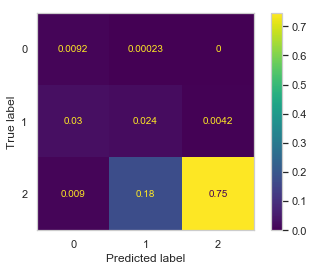

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(test_y, pred_y)

disp = ConfusionMatrixDisplay(confusion_matrix=cm/cm.sum(), display_labels=[0,1,2])
disp.plot(include_values=True,
                     cmap='viridis', ax=None,# xticks_rotation='horizontal',
                     values_format=None)
plt.grid('off')

In [24]:
importances = clf_1.feature_importances_
df = pd.DataFrame([train_X.columns.tolist(), importances.tolist()])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32
1,0.00427754,0.00253019,0.0263714,0.0176759,0.161279,0,0.107183,0.00982441,0.0883908,0.199009,0.111383,0.0151573,0.0694569,0.0673025,0.0222622,0.037288,0.0606078


Feature ranking:
1. feature 9 - Ps30 (0.199009)
2. feature 4 - T50 (0.161279)
3. feature 10 - phi (0.111383)
4. feature 6 - P30 (0.107183)
5. feature 8 - Nc (0.088391)
6. feature 12 - NRc (0.069457)
7. feature 13 - BPR (0.067302)
8. feature 16 - W32 (0.060608)
9. feature 15 - W31 (0.037288)
10. feature 2 - T24 (0.026371)
11. feature 14 - htBleed (0.022262)
12. feature 3 - T30 (0.017676)
13. feature 11 - NRf (0.015157)
14. feature 7 - Nf (0.009824)
15. feature 0 - setting_1 (0.004278)
16. feature 1 - setting_2 (0.002530)
17. feature 5 - P15 (0.000000)


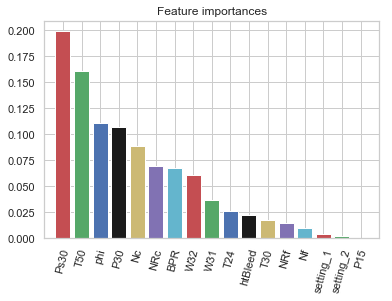

In [25]:

std = np.std([clf_1.feature_importances_ for tree in clf_1.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(train_X.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], train_X.columns.tolist()[indices[f]], importances[indices[f]]))

xtick = [train_X.columns.tolist()[indices[i]] for i in range(train_X.shape[1])] 

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_X.shape[1]), importances[indices],
       color=list('rgbkymc'), yerr=std[indices], align="center")
plt.xticks(range(train_X.shape[1]), xtick, rotation=75)
plt.xlim([-1, train_X.shape[1]])
plt.show()

The list of important features here is matching with the correlation table in the section 3.3.

Especially, the columns Ps30, T50, phi, P30, Nc, W32 are highly correlated to the RUL, hence, also to label1 and label2.

**Remarks:** One of the reason that the Random Forest didn't work well is it haven't utilized all past data.

## Generate sequence input data for the deep learning models
Why have I chosen a specific framework?

We will transform the data into the sequence format to input to our Recurrent neural network later on. In addition, we expect our model might remember the behaviour of the aircraft engine before the current flight. 

In [26]:
sequence_length = 60

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    # 0 50 (start stop) -> from row 0 to row 50
    # 1 51 (start stop) -> from row 1 to row 51
    # 2 52 (start stop) -> from row 2 to row 52
    # ...
    # 141 191 (start stop) -> from row 141 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

In [27]:
### SEQUENCE COL: COLUMNS TO CONSIDER ###
sequence_cols = train_df.columns.tolist()[2:-3]
print(sequence_cols)

nb_features = len(sequence_cols)

['setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']


In [28]:
### GENERATE X TRAIN TEST BY USING THE SEQUENCE INPUT ###
x_train, x_test = [], []
for engine_id in train_df.id.unique():
    for sequence in gen_sequence(train_df[train_df.id==engine_id], sequence_length, sequence_cols):
        x_train.append(sequence)
    for sequence in gen_sequence(test_df[test_df.id==engine_id], sequence_length, sequence_cols):
        x_test.append(sequence)
    
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)

X_train shape: (14631, 60, 17)
X_test shape: (7263, 60, 17)


In [29]:
### GENERATE Y TRAIN TEST ###
y_train, y_test = [], []
for engine_id in train_df.id.unique():
    for label in gen_labels(train_df[train_df.id==engine_id], sequence_length, ['label2'] ):
        y_train.append(label)
    for label in gen_labels(test_df[test_df.id==engine_id], sequence_length, ['label2']):
        y_test.append(label)
    
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (14631, 1)
y_test shape: (7263, 1)


In [30]:
### ENCODE LABEL ###
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(14631, 3)
(7263, 3)


## Feed Forward network

In [31]:
ffn_filepath = "../hdf5_models/RUL_FFN.hdf5"
checkpoint = ModelCheckpoint(ffn_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

model_2 = Sequential()
# model.name= 'Classification'

model_2.add(Dense(32,
         input_shape=(sequence_length, nb_features), ## (50,17)
        activation = 'relu'))
model_2.add(Dropout(0.25))


model_2.add(Dense(64, activation = 'relu'))
model_2.add(Dropout(0.25))

model_2.add(Flatten())

model_2.add(Dense(units=3, activation='sigmoid'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

print(model_2.summary())

W0501 04:26:26.034144 140531367757696 deprecation.py:506] From /home/philip/.virtualenvs/deep_learn_py3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60, 32)            576       
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 60, 64)            2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3840)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 11523     
Total params: 14,211
Trainable params: 14,211
Non-trainable params: 0
____________________________________________________

### FFN Training step

In [32]:
BATCH_SIZE = 256
EPOCHS = 25

history = model_2.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=[checkpoint],
                      validation_split=0.2,
                      verbose=1)

W0501 04:26:26.243235 140531367757696 deprecation.py:323] From /home/philip/.virtualenvs/deep_learn_py3/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 11704 samples, validate on 2927 samples
Epoch 1/25
11520/11704 [============================>.] - ETA: 0s - loss: 0.7637 - acc: 0.6754
Epoch 00001: val_acc improved from -inf to 0.78681, saving model to ../hdf5_models/RUL_FFN.hdf5
11704/11704 [==============================] - 1s 79us/sample - loss: 0.7602 - acc: 0.6768 - val_loss: 0.4913 - val_acc: 0.7868
Epoch 2/25
11264/11704 [===========================>..] - ETA: 0s - loss: 0.4765 - acc: 0.7930
Epoch 00002: val_acc improved from 0.78681 to 0.80492, saving model to ../hdf5_models/RUL_FFN.hdf5
11704/11704 [==============================] - 1s 62us/sample - loss: 0.4745 - acc: 0.7938 - val_loss: 0.4332 - val_acc: 0.8049
Epoch 3/25
11520/11704 [============================>.] - ETA: 0s - loss: 0.3882 - acc: 0.8306
Epoch 00003: val_acc improved from 0.80492 to 0.84387, saving model to ../hdf5_models/RUL_FFN.hdf5
11704/11704 [==============================] - 1s 58us/sample - loss: 0.3872 - acc: 0.8310 - val_loss: 0.3452 - val_

In [33]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

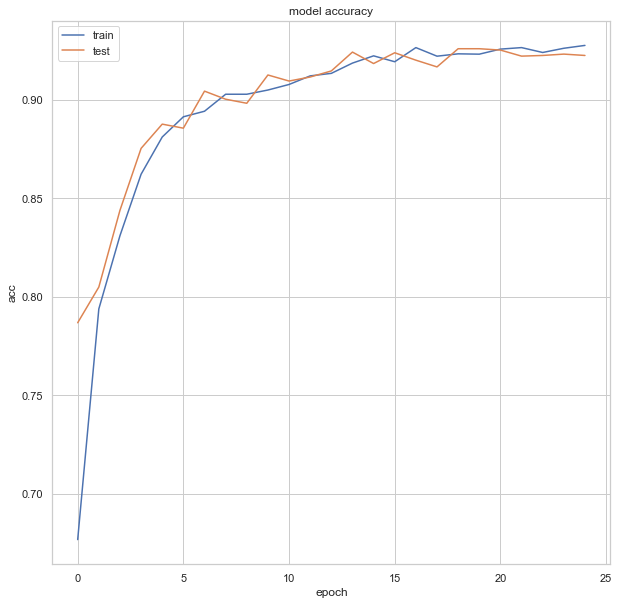

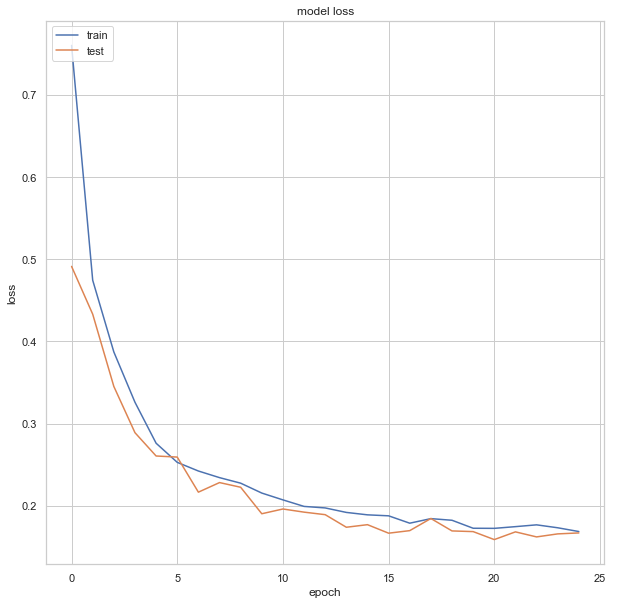

In [34]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("../training/fnn_model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("../training/fnn_model_loss.png")


In [35]:
### LOAD BEST MODEL ###
best_model = load_model(ffn_filepath)

model_2.evaluate(x_test, y_test, verbose=1)[1]

W0501 04:26:45.694294 140531367757696 deprecation.py:506] From /home/philip/.virtualenvs/deep_learn_py3/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0501 04:26:45.696167 140531367757696 deprecation.py:506] From /home/philip/.virtualenvs/deep_learn_py3/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


7263/7263 [==============================] - 0s 48us/sample - loss: 0.7097 - acc: 0.8044


0.8043508

In [36]:
y_pred_origin = model_2.predict(x_test)
y_pred = np.argmax(y_pred_origin, axis=1)

In [37]:
y_test = np.argmax(y_test, axis=1)
print('accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy 0.8043508192207077
              precision    recall  f1-score   support

           0       0.26      1.00      0.41       123
           1       0.28      0.53      0.36       763
           2       1.00      0.83      0.91      6377

    accuracy                           0.80      7263
   macro avg       0.51      0.79      0.56      7263
weighted avg       0.91      0.80      0.84      7263



### Confusion matrix

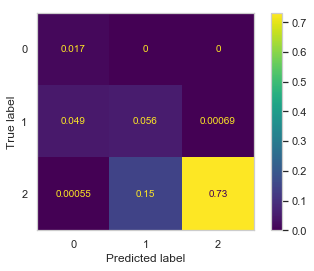

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm/cm.sum(), display_labels=[0,1,2])
disp.plot(include_values=True,
                     cmap='viridis', ax=None,# xticks_rotation='horizontal',
                     values_format=None)
plt.grid('off')

## Recurrent Neural Network

In [39]:
rnn_filepath = "../hdf5_models/RUL_RNN.hdf5"
checkpoint = ModelCheckpoint(rnn_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

model_3 = Sequential()
# model.name= 'Classification'
model_3.add(LSTM(
         input_shape=(sequence_length, nb_features), ## (50,17)
         units=120,
         return_sequences=True))
model_3.add(Dropout(0.25))


model_3.add(LSTM(
          units=60,
          return_sequences=False))
model_3.add(Dropout(0.25))

model_3.add(Dense(units=3, activation='sigmoid'))
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

print(model_3.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 120)           66240     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 120)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                43440     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 183       
Total params: 109,863
Trainable params: 109,863
Non-trainable params: 0
_________________________________________________________________
None


### RNN Training step

In [40]:
BATCH_SIZE = 256
EPOCHS = 25

history = model_3.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=[checkpoint],
                      validation_split=0.2,
                      verbose=1)

Train on 11704 samples, validate on 2927 samples
Epoch 1/25
11520/11704 [============================>.] - ETA: 0s - loss: 0.7136 - acc: 0.7051
Epoch 00001: val_acc improved from -inf to 0.80799, saving model to ../hdf5_models/RUL_RNN.hdf5
11704/11704 [==============================] - 10s 848us/sample - loss: 0.7102 - acc: 0.7070 - val_loss: 0.4416 - val_acc: 0.8080
Epoch 2/25
11520/11704 [============================>.] - ETA: 0s - loss: 0.3534 - acc: 0.8629
Epoch 00002: val_acc improved from 0.80799 to 0.86573, saving model to ../hdf5_models/RUL_RNN.hdf5
11704/11704 [==============================] - 9s 768us/sample - loss: 0.3540 - acc: 0.8624 - val_loss: 0.2973 - val_acc: 0.8657
Epoch 3/25
11520/11704 [============================>.] - ETA: 0s - loss: 0.2557 - acc: 0.8973
Epoch 00003: val_acc improved from 0.86573 to 0.87667, saving model to ../hdf5_models/RUL_RNN.hdf5
11704/11704 [==============================] - 9s 745us/sample - loss: 0.2547 - acc: 0.8978 - val_loss: 0.2783 - 

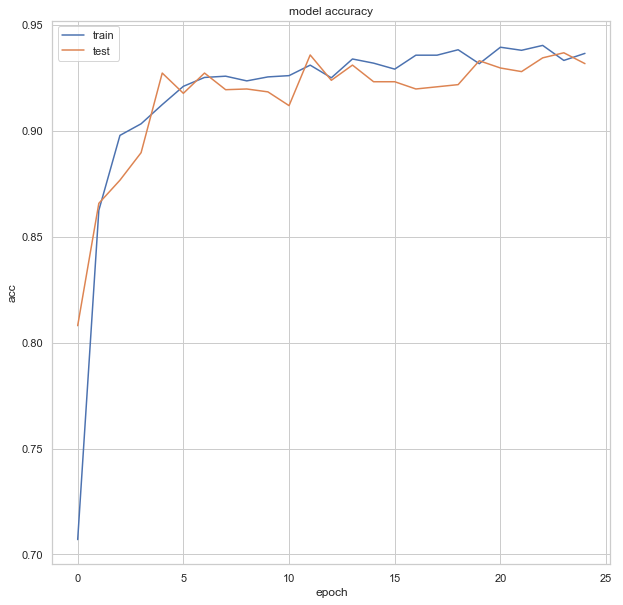

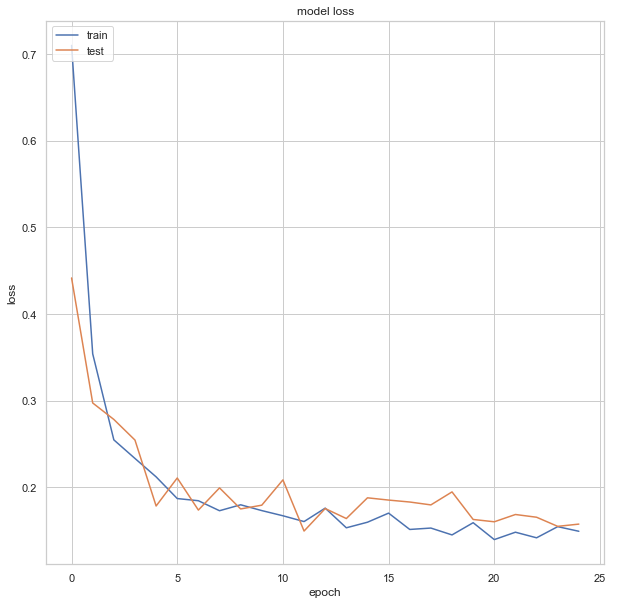

In [41]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("../training/rnn_model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("../training/rnn_model_loss.png")


In [42]:
y_pred_origin = model_3.predict(x_test)
y_pred = np.argmax(y_pred_origin, axis=1)
print('accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy 0.7580889439625499
              precision    recall  f1-score   support

           0       0.16      1.00      0.28       123
           1       0.19      0.35      0.25       763
           2       1.00      0.80      0.89      6377

    accuracy                           0.76      7263
   macro avg       0.45      0.72      0.47      7263
weighted avg       0.90      0.76      0.81      7263



In [43]:
y_pred_origin, y_pred, y_test

(array([[1.2654066e-04, 3.5263598e-03, 9.6944773e-01],
        [1.2907386e-04, 3.5398901e-03, 9.6790850e-01],
        [1.2558699e-04, 3.1863749e-03, 9.6849370e-01],
        ...,
        [9.7885215e-01, 3.2027364e-03, 3.9246678e-04],
        [9.7934258e-01, 3.1917125e-03, 3.9384092e-04],
        [9.7975069e-01, 3.1841723e-03, 3.9385183e-04]], dtype=float32),
 array([2, 2, 2, ..., 0, 0, 0]),
 array([2, 2, 2, ..., 1, 1, 0]))

### Confusion matrix

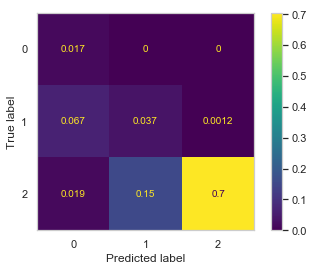

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm/cm.sum(), display_labels=[0,1,2])
disp.plot(include_values=True,
                     cmap='viridis', ax=None,# xticks_rotation='horizontal',
                     values_format=None)
plt.grid('off')

# Final Remark
+ The model is rather sensitive on the two thresholds of w0 and w1.
+ We might still want to tune the Deep learning models (both FFN and RNN) further for better results
+ A regression model can also be built to predict the RUL of aircraft engine.

# References

- [1] A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Research Center, Moffett Field, CA 

- [2] Deep Learning for Predictive Maintenance https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb

- [3] Understanding LSTM Networks http://colah.github.io/posts/2015-08-Understanding-LSTMs/